<a href="https://colab.research.google.com/github/haseungchung/Machine-Learning-and-Deep-Learning-Projects/blob/main/Deep%20Learning%20Based%20Signal%20Constellation%20Design%20Using%20an%20Autoencoder/Intro_to_DL_for_the_Physical_Layer_Autoencoder_Pentagon(Average_Power)_Stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip uninstall tensorflow
# !pip uninstall keras
# !pip install tensorflow-gpu==2.0.0
# !pip install keras==2.3.1
print(keras.__version__)
print(tf.__version__)

2.3.1
2.0.0


In [2]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import openpyxl
from openpyxl.reader.excel import load_workbook
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout,Add,Concatenate
from keras.models import Model
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from google.colab import files

Using TensorFlow backend.


In [4]:
# for reproducing result
tf.random.set_seed(3)

In [5]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 16
k = np.log2(M)
k = int(k)
n_channel = 2
R = k/n_channel
max_val=1
print ('M:',M,'k:',k,'n:',n_channel)
prop=300

M: 16 k: 4 n: 2


In [6]:
#generating data of size N
N = 75000
label = np.random.randint(M,size=N)

In [7]:
# creating one hot encoded vectors
data=np.zeros([N,M])
for i in range(len(label)):
    data[i][label[i]] = 1


EbNo_train = 5.01187 #  coverted 7 db of EbNo
noise=np.random.normal(0,np.sqrt(1/(2*R*EbNo_train)),[N,n_channel])

In [8]:
''' a custom activation function for amplitude constraint (~QAM style)'''
def mapping_to_target_range( x, target_min=-np.sqrt(max_val), target_max=np.sqrt(max_val) ) :
    x02 = K.tanh(x)+1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

'''a custom loss function for the average power constraint (~unique result)'''
def custom_loss(signal):
    def loss(y_true, y_pred):
        sloss = K.switch(K.greater((K.sum(K.square(signal))),K.constant(max_val)),K.sum(K.square(signal))-K.constant(max_val),K.constant(0))
        return sloss/prop+keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss

# defining autoencoder and its layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization()(encoded1) #average power
# encoded2 = Dense(n_channel, activation=mapping_to_target_range)(encoded1) #QAM style
''' an activation function for energy constraint (~PSK style)'''
# encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1) #only implement for the energy constraint

inputnoise = Input(shape=(n_channel,))
encoded3 = Add()([inputnoise,encoded2])

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model([input_signal,inputnoise], decoded1)
adam = Adam(learning_rate=0.005)
autoencoder.compile(optimizer=adam, loss=custom_loss(encoded2)) #only implement for average power constraint
# autoencoder.compile(optimizer=adam, loss='categorical_crossentropy') #loss for every other constraint
# autoencoder summary
print (autoencoder.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            34          dense_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2)            0                                            
____________________________________________________________________________________________

In [10]:
# traning the autoencoder

autoencoder.fit([data,noise], data,
                epochs=75,
                batch_size=int(M*5))

Train on 75000 samples, validate on 1500 samples
Epoch 1/75
75000/75000 [==============================] - 2s 29us/step - loss: 1.1396 - val_loss: 0.7672
Epoch 2/75
75000/75000 [==============================] - 2s 26us/step - loss: 0.8380 - val_loss: 0.7409
Epoch 3/75
75000/75000 [==============================] - 2s 26us/step - loss: 0.8300 - val_loss: 0.7287
Epoch 4/75
75000/75000 [==============================] - 2s 26us/step - loss: 0.8211 - val_loss: 0.7482
Epoch 5/75
75000/75000 [==============================] - 2s 27us/step - loss: 0.8164 - val_loss: 0.7099
Epoch 6/75
75000/75000 [==============================] - 2s 26us/step - loss: 0.8167 - val_loss: 0.7046
Epoch 7/75
75000/75000 [==============================] - 2s 25us/step - loss: 0.8129 - val_loss: 0.7095
Epoch 8/75
75000/75000 [==============================] - 2s 25us/step - loss: 0.8211 - val_loss: 0.6991
Epoch 9/75
75000/75000 [==============================] - 2s 26us/step - loss: 0.8157 - val_loss: 0.6990
Epoch 

In [11]:
# isolating the encoder section from full autoencoder
encoder = Model([input_signal,inputnoise], encoded3)

In [12]:
# isolating the decoder section from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [13]:
# Making test data
Ntest = 50000
test_label = np.random.randint(M,size=Ntest)
test_data=np.zeros([Ntest,M])
for i in range(len(test_label)):
    test_data[i][label[i]] = 1

In [14]:
# for plotting learned constallation diagram
scatter_plot = []
scatter_plot_nn = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict([np.expand_dims(temp,axis=0),np.random.normal(0,np.sqrt(1/(2*R*EbNo_train)),[1,2])]))
    scatter_plot_nn.append(encoder.predict([np.expand_dims(temp,axis=0),np.random.normal(0,0.01,[1,2])]))
    # print(np.expand_dims(temp,axis=0).shape)
scatter_plot = np.array(scatter_plot)
scatter_plot_nn = np.array(scatter_plot_nn)
print(scatter_plot.shape)
print(scatter_plot_nn.shape)

(16, 1, 2)
(16, 1, 2)


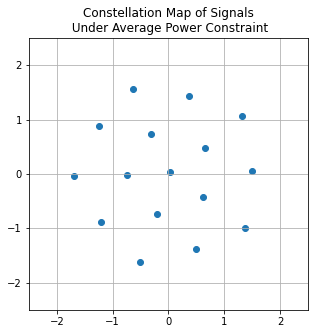

In [15]:
# # plotting constellation diagram
import matplotlib.pyplot as plt
'''Average Power Constraint'''
plt.figure(figsize=(5, 5))
plt.title("Constellation Map of Signals\n Under Average Power Constraint")
scatter_plot_nn = scatter_plot_nn.reshape(M,2,1)
plt.scatter(scatter_plot_nn[:,0],scatter_plot_nn[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()